In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
np.random.seed(1337)
from keras.models import Model
from keras.layers import Dense, Input, Activation, Dropout, Flatten, Bidirectional
from keras.layers import Convolution1D, MaxPooling1D, LSTM, BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras import initializers
from keras.utils import np_utils, to_categorical
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras import backend as K
import tensorflow as tf
import sys
#import pickle
import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping,TensorBoard
#from keras.models import model_from_json
#import json
from keras import regularizers
#import matplotlib.pyplot as plt
import os
#import os.path
import errno
from livelossplot import PlotLossesKeras

In [4]:
# **Hardware Choices:**
# 
# 0 = GPU 0
# 
# 1 = GPU 1
# 
# 2 = CPU

# What is your hardware choice
proc_hardware_choice = 0


if proc_hardware_choice == 0:
    proc_hardware_name = '/gpu:0'
    
elif proc_hardware_choice == 1:
    proc_hardware_name = '/gpu:1'
    
elif proc_hardware_choice == 2:
    proc_hardware_name = '/cpu:0'
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print('ERROR: You didnt make a proper choice. Defaulting to CPU processing.')
    proc_hardware_name = '/cpu:0'
    
print('\nUsing hardware name =', proc_hardware_name)


Using hardware name = /gpu:0


In [5]:
# The ML model
def tatooine_new2(data_shape):

    inputs = Input(shape=data_shape) #(X_train.shape[1], 1)

    # Convolution layer 1 (input layer) #kernel size -> min feature size ( full dur of smallest transit, how many px is that)
    layer = Convolution1D(filters=16, kernel_size=32, strides=1, kernel_initializer='glorot_uniform')(inputs)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)

    # Convolution layer 2
    layer = Convolution1D(filters=16, kernel_size=32, strides=1, kernel_initializer='glorot_uniform')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)

    layer = MaxPooling1D(pool_size=8)(layer) # pool size something divisible 
    #mean pooling also an option, might help...use both.. concatenate max and mean pool results and pass that on 

    # Convolution layer 3
    layer = Convolution1D(filters=32, kernel_size=32, strides=1, kernel_initializer='glorot_uniform')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)

    # Convolution layer 4
    layer = Convolution1D(filters=32, kernel_size=32, strides=1, kernel_initializer='glorot_uniform')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)

    layer = MaxPooling1D(pool_size=8)(layer)
        #mean pooling also an option, might help...use both.. concatenate max and mean pool results and pass that on 

    # Flatten convolution outputs
    layer = Flatten()(layer)

    # Dense layer 1
    layer = Dense(512, kernel_initializer='glorot_uniform')(layer) #2048
    layer = Activation('relu')(layer)
#     layer = Dropout(0.5)(layer) # too much

    # Dense layer 2
    layer = Dense(512, kernel_initializer='glorot_uniform')(layer) #2048
    layer = Activation('relu')(layer)
#     layer = Dropout(0.5)(layer) # too much

    # Output layer
    layer = Dense(1)(layer)
    layer = Activation('sigmoid')(layer)

    return Model(inputs, layer)

In [6]:
#################################
###### User Options #############
#################################
test_data_plots_q = 1

batch_size = 32
epochs = 100
data_dir = os.getcwd()
log_dir = os.path.join(os.getcwd(), 'hsp_2_tb_logs_9')
checkpoint_dir = os.path.join(os.getcwd(), 'hsp_2_tf_train_checkpoints_9')

In [6]:
# If log_dir does not exist, create it
if not os.path.isdir(log_dir):

    os.mkdir(log_dir)

# If checkpoint_dir does not exist, create it
if not os.path.isdir(checkpoint_dir):

    os.mkdir(checkpoint_dir)

In [7]:
# lf = np.load('training_data_v1.npz')
# lf = np.load('hsp_training_data_8192_v2.npz')
lf = np.load('training_data/new_training_data_v3.npz')

negative_matrix = lf['neg']
#transits_clean = lf['transits_clean']
positive_matrix = lf['transits']
params = lf['params']

In [8]:
test = positive_matrix[0]
len(test)

8192

In [9]:
def mk_set(positive_matrix, negative_matrix):
    
    print("Creating X")
    
    X_train = np.vstack((positive_matrix, negative_matrix))
    
    print("Creating Y")

    y_train = np.hstack((np.ones_like(positive_matrix[:,0]), np.zeros_like(negative_matrix[:,0])))

    sidx = np.arange(X_train.shape[0])

    np.random.shuffle(sidx)

    X_train = X_train[sidx, :]
    
    print("Created X Train set")

    y_train = y_train[sidx]
    
    print("Created Y Train set")
    
    return X_train, y_train

In [10]:
X_test, y_test = mk_set(positive_matrix[:25000], negative_matrix[:25000])

Creating X
Creating Y
Created X Train set
Created Y Train set


In [11]:
X_train, y_train = mk_set(positive_matrix[250000:], negative_matrix[250000:])
# This works, don't change it otherwise you dead kernel

Creating X
Creating Y
Created X Train set
Created Y Train set


In [12]:
y_train = y_train.reshape((-1, 1))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

y_test = y_test.reshape((-1, 1))
print("Created Y Test set")
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("Created X Test set")

Created Y Test set
Created X Test set


In [ ]:
tf.keras.backend.clear_session() # Clears all saved model weights and the model!! CAREFUL!!

In [8]:
# Show model summary
#for i in np.arange(10):

#print('training %s' % i)

# model = tatooine_new2((X_train.shape[1], 1))

model = tatooine_new2((8192, 1))
model.summary()

# model = tf.keras.models.load_model('hsp_big_model_v3_save1.hd5')
# model.summary()
# model.load_weights('hsp_big_model1_v3.hdf5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8192, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8161, 16)          528       
_________________________________________________________________
batch_normalization (BatchNo (None, 8161, 16)          64        
_________________________________________________________________
activation (Activation)      (None, 8161, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8130, 16)          8208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8130, 16)          64        
_________________________________________________________________
activation_1 (Activation)    (None, 8130, 16)         

In [14]:
# Train and test the model

# Set optimization options
#optimization = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimization = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.005, amsgrad=False)
#optimization = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
optimization = Adam(lr=1e-6)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimization, metrics=['accuracy'])

# Set early stopping (training) options
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')

# Setup training checkpoint options
# model_checkpoint = ModelCheckpoint('model1.hdf5', monitor='val_loss', save_best_only=True)
model_checkpoint = ModelCheckpoint('hsp_big_model1_v9.hdf5', monitor='val_loss', save_best_only=True)

callbacks = [model_checkpoint, PlotLossesKeras()]

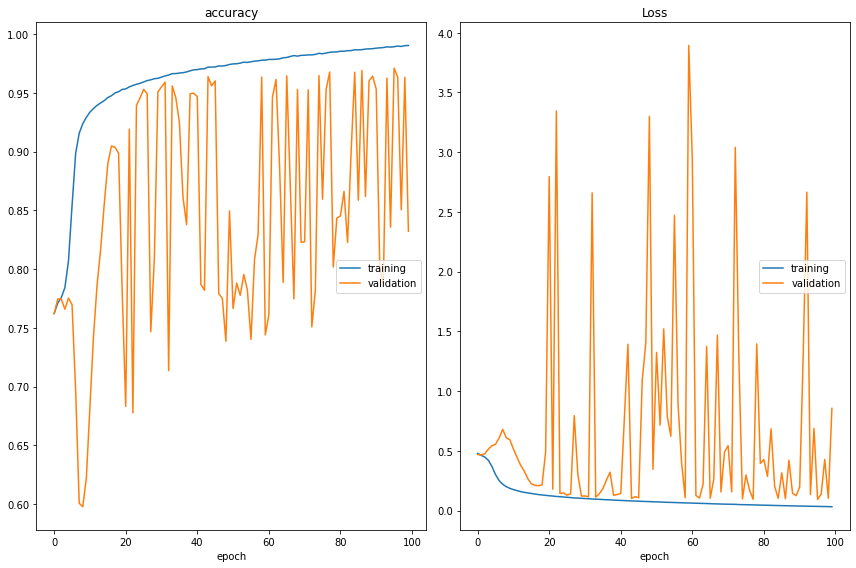

accuracy
	training         	 (min:    0.762, max:    0.990, cur:    0.990)
	validation       	 (min:    0.598, max:    0.971, cur:    0.832)
Loss
	training         	 (min:    0.032, max:    0.479, cur:    0.032)
	validation       	 (min:    0.094, max:    3.893, cur:    0.855)
2188/2188 [==============================] - 31s 14ms/step - loss: 0.0319 - accuracy: 0.9904 - val_loss: 0.8549 - val_accuracy: 0.8322


In [15]:
with tf.device(proc_hardware_name):

    # Begin Training
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.3,
              shuffle=True,
              callbacks=callbacks)

In [16]:
# model.save('model_v1_save1.hd5')
model.save('hsp_big_model_v9_save1.hd5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: hsp_big_model_v9_save1.hd5/assets


In [17]:
model = tf.keras.models.load_model('hsp_big_model_v9_save1.hd5')

In [9]:
# model.load_weights('model1.hdf5')
model.load_weights('hsp_big_model1_v9.hdf5')

In [ ]:
# len(y_pred)

In [19]:
# Test the accuracy of the model
y_pred = model.predict(X_test)
# y_pred = np.around(y_pred)

#print(y_pred.round())
#print(y_test)
print(accuracy_score(y_test, y_pred.round()) )
print(precision_score(y_test, y_pred.round()) )
print(recall_score(y_test, y_pred.round()) )
print(f1_score(y_test, y_pred.round()) )
print(roc_auc_score(y_test, y_pred.round()) )

0.97182
0.9909677419354839
0.95232
0.9712595614482408
0.97182


In [21]:
from sklearn.metrics import confusion_matrix
import itertools

In [22]:
cm = confusion_matrix(y_true=y_test, y_pred=np.around(y_pred))
print(len(y_test))
print(len(y_pred))
print(type(y_pred))

50000
50000
<class 'numpy.ndarray'>


In [23]:
from mpl_toolkits import mplot3d


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    


In [24]:
cm_plot_labels = ['No','Yes']

Confusion matrix, without normalization
[[24783   217]
 [ 1192 23808]]


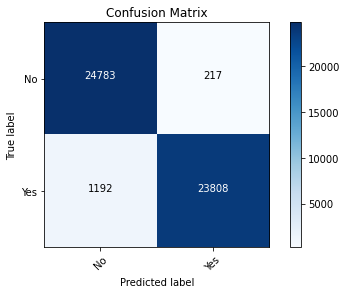

In [26]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
import random

if 1:

#     sp_cnt = 3
    sp_cnt = 4

    ip = ''

#     print(np.shape(X_train), np.shape(y_train), np.shape(y_pred))
    print(np.shape(X_test), np.shape(y_test), np.shape(y_pred))

#     ind_arr = list(range(len(y_train)))
    ind_arr = list(range(len(y_test)))
    random.shuffle(ind_arr)
    i = 0
#     while ip != 'x':
    for i in range(10):
        #was 15,4
#         plt.figure(10, figsize=(9,4.5))
        plt.figure(10, figsize=(15,20))
        plt.clf()

        for spi in np.arange(sp_cnt):
            plt.subplot(sp_cnt, 1, spi + 1)
#             plt.plot(X_train[ind_arr[i+spi], :], '.k')
#             plt.title('Has planet? ' + str(y_train[ind_arr[i+spi]]) + ' | Prediction? ' + str(y_pred[ind_arr[i+spi]]))
                #plt.ylim(0.990, 1.001)
            plt.plot(X_test[ind_arr[i+spi], :], '.k')
            plt.title('Has planet? ' + str(y_test[ind_arr[i+spi]]) + ' | Prediction? ' + str(y_pred[ind_arr[i+spi]]))

        plt.subtitle('(Synthetic) Test data')
        plt.show()
#         i = i + 3
        i = i + 2
#         ip = input('Press "x" to stop plotting or enter to show more   ')


In [28]:
ind_arr = list(range(len(y_test)))
print(X_test.shape)
print(len(y_pred))
print(len(y_test))
for j in range(len(y_test)):
    if (np.mod(j, 20000) == 0):
        print(j)
#         plt.figure(10, figsize=(15,9))
#         plt.plot(X_train[ind_arr[j], :], '.r')
#         plt.title('Has planet? ' + str(y_test[ind_arr[j]]) + ' | Prediction? ' + str(y_pred[ind_arr[j]]))
#         plt.show()
#     if (y_test[ind_arr[j]] != y_pred[ind_arr[j]]):
#         plt.figure(10, figsize=(15,9))
#         plt.plot(X_test[ind_arr[j], :], '.k')
#         plt.title('Has planet? ' + str(y_test[ind_arr[j]]) + ' | Prediction? ' + str(y_pred[ind_arr[j]]))
#         plt.show()
    if (y_test[ind_arr[j]] != np.around(y_pred[ind_arr[j]])):
        plt.figure(10, figsize=(15,9))
        plt.plot(X_test[ind_arr[j], :], '.k')
        plt.title('Has planet? ' + str(y_test[ind_arr[j]]) + ' | Prediction? ' + str(y_pred[ind_arr[j]]))
#         plt.show()
        plt.savefig('/media/rd3/cchen/cchen/kepler_ml_v3/training_figs/nov7/training_fails/' + 'predicted_' + str(y_pred[ind_arr[j]]) + 'actual_'+ str(y_test[ind_arr[j]]) + '.png')
        plt.close()
    


(50000, 8192, 1)
50000
50000
0
20000
40000


In [ ]:
# # for i in range(len(y_test)):
    


# plt.figure()
# ax = plt.axes(projection='3d')
# zdata = 15 * np.random.random(100)
# xdata = y_test
# ydata = y_pred
# ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Blues');

In [10]:
import pandas as pd
# hsps = pd.read_excel("hsp_60_400_days_v2.xlsx")
hsps = pd.read_excel("hsps_100_200_days.xlsx")

# hsp_kic = hsps['kic']
# hsp_per = hsps['period (d)']
# hsp_dur = hsps['transit_dur (h)']
# hsp_depth = hsps['transit_depth (ppm)']
kid_list = hsps['kic']

save_dir = '/media/rd3/cchen/cchen/hsp_gpu_fold/hsp_100to200/'

In [11]:
# def load_folds(kid, save_dir, bin_cnt=8192):
    
#     fn = 'data_' + str(kid) + '_hps.bin'
    
#     fp = os.path.join(save_dir, fn)
    
#     print(np.fromfile(fp, dtype='double'))
    
#     return np.fromfile(fp, dtype='double').reshape(38400, bin_cnt)

# #def 

In [ ]:
# Test individual target

i = 0

kid = kid_list.iloc[i]

lcf = load_folds(kid, save_dir)
# print(len(lcf))

In [ ]:
np.shape(lcf)

In [ ]:
np.shape(X_test)

In [ ]:
#y_test = y_test.reshape((-1, 1))

lcf_test = lcf.reshape((lcf.shape[0], lcf.shape[1], 1))

In [ ]:
np.shape(lcf_test)

In [ ]:
y_pred0 = model.predict(lcf_test)
y_pred = np.around(y_pred0)

In [ ]:
plt.figure()
plt.plot(y_pred0, '.k')

# Test on real data (106 USPs, GPU folded)

In [ ]:
# import pandas as pd

# df = pd.read_csv('/media/rd1/TESS/Kevin_Code/Folding_106_Lightcurves/106_Kepler_USP_Characteristics.csv')

# df
import pandas as pd
hsps = pd.read_excel("hsp_60_400_days_v2.xlsx")
# hsp_kic = hsps['kic']
# hsp_per = hsps['period (d)']
# hsp_dur = hsps['transit_dur (h)']
# hsp_depth = hsps['transit_depth (ppm)']
kid_list = hsps['kic']



In [12]:
def load_folds(kid, save_dir, bin_cnt=8192):
    
    fn = 'data_' + str(kid) + '_hps.bin'
    
    fp = os.path.join(save_dir, fn)
    
    print(np.fromfile(fp, dtype='double'))
    
#     return np.fromfile(fp, dtype='double').reshape(38400, bin_cnt)
    return np.fromfile(fp, dtype='double').reshape(44000, bin_cnt)


In [13]:
# save_dir = '/media/rd1/kwillis/kepler_ml/kepler_ml_v3/lc_folds'
save_dir = '/media/rd3/cchen/cchen/hsp_gpu_fold/hsp_100to200/'

In [ ]:
# Test individual target

i = 0

kid = kid_list.iloc[i]

lcf = load_folds(kid, save_dir)
# print(len(lcf))

In [ ]:
np.shape(lcf)

In [ ]:
np.shape(X_test)

In [ ]:
#y_test = y_test.reshape((-1, 1))

lcf_test = lcf.reshape((lcf.shape[0], lcf.shape[1], 1))

In [ ]:
np.shape(lcf_test)

In [ ]:
y_pred0 = model.predict(lcf_test)
# y_pred = np.around(y_pred0)

In [ ]:
plt.figure()
#plt.title('P='+str(p) + ' | KID ' + str(kid))
plt.plot(y_pred0, '.k')

In [ ]:
kid

In [ ]:
plt.figure()
plt.plot(lcf[1000,:], '-k')
plt.plot(lcf[999,:], '.r', alpha=0.3)

In [ ]:
r1 = np.random.randint(0, len(y_test))
r2 = np.random.randint(0, len(y_test))

plt.figure()
plt.plot(X_test[r1,:, 0], '-k', label=str(y_test[r1]))
plt.plot(X_test[r2,:, 0], '-r', label=str(y_test[r2]))
plt.legend()

In [ ]:
plt.figure()
#plt.title('P='+str(p) + ' | KID ' + str(kid))
plt.plot(y_pred0, '.k')

plt.axhline(np.std(y_pred0) * 10 + np.mean(y_pred0))

In [ ]:
gi = y_pred0 <= np.std(y_pred0) * 2 + np.mean(y_pred0)

gii = np.argwhere(gi)[:,0]

yp = y_pred0[gi]

gii

In [ ]:
si = np.flip(np.argsort(yp))

gii_si = gii[si]

In [ ]:
plt.figure()
plt.plot(lcf[gii_si[0],:], '-k')

In [14]:
# # period_search_array = np.linspace(0.01, 1.0, 100000)
# period_search_array = np.linspace(100, 500, 38400)
period_search_array = np.linspace(100, 200, 44000)

In [ ]:
period_search_array[gii_si[0]]

In [ ]:
p = hsps['period (d)'].iloc[i] #df['Period'].iloc[i]

i, p

In [ ]:
p = hsps['period (d)'].iloc[i] #df['Period'].iloc[i]

# phs = np.arange(0.0, 1.0 / p + 0.5, 0.5)
phs = np.arange(100.0, 500.0 / p + 250.0, 250.0)

In [ ]:
# phs = np.arange(0.0, 1.0 / p + 0.5, 0.5)

phs

In [15]:
%matplotlib notebook

In [ ]:
# p, np.arange(0.0, 1.0 / p + 0.5, 0.5), phs

In [ ]:
xx = np.arange(len(y_pred0))

plt.figure()
#plt.title('P='+str(p) + ' | KID ' + str(kid))
plt.plot(period_search_array, y_pred0, '.k')

# phs = np.arange(0.0, 1.0 / p + 0.5, 0.5) * p
phs = np.arange(100, 500 / p + 250, 250) * p

for ph in phs:
    
    bv = np.argmin(np.abs(period_search_array - ph))
    
    plt.plot(period_search_array[bv], y_pred0[bv], '*r')

plt.axhline(np.std(y_pred0) * 3 + np.mean(y_pred0))

In [ ]:
i = 0

bv = gii_si[i]

plt.figure()
plt.subplot(2,1,1)
plt.title('p fold = ' + str(period_search_array[bv]) + ' | p diff = ' + str(period_search_array[bv] - p) + ' | p div = ' + str(period_search_array[bv] / p))
plt.plot(np.roll(lcf[bv,:], 120), '-k')

plt.subplot(2,1,2)
plt.plot(period_search_array, y_pred0, '.k')
plt.plot(period_search_array[bv], y_pred0[bv], '*r')

In [ ]:

for i in range(5):

    bv = gii_si[i]

    plt.figure()
    plt.subplot(2,1,1)
    plt.title('p fold = ' + str(period_search_array[bv]) + ' | p diff = ' + str(period_search_array[bv] - p) + ' | p div = ' + str(period_search_array[bv] / p))
    plt.plot(lcf[bv,:], '-k')

    plt.subplot(2,1,2)
    plt.plot(period_search_array, y_pred0, '.k')
    plt.plot(period_search_array[bv], y_pred0[bv], '*r')

In [16]:
def nstr(s):
    
    return str(np.around(s, 5))

In [ ]:
bv = np.argmin(np.abs(period_search_array - p))
    
plt.figure()
plt.subplot(2,1,1)
plt.title('p actual = ' + nstr(p) + ' | p fold = ' + nstr(period_search_array[bv]) + ' | p diff = ' + nstr(period_search_array[bv] - p) + ' | p div = ' + nstr(period_search_array[bv] / p))
plt.plot(lcf[bv,:], '-k')

plt.subplot(2,1,2)
plt.plot(period_search_array, y_pred0, '.k')
plt.plot(period_search_array[bv], y_pred0[bv], '*r')

In [ ]:
for ph in phs:
    
    bv = np.argmin(np.abs(period_search_array - ph))
    
    plt.figure()
    plt.title('p fold = ' + nstr(period_search_array[bv]) + ' | p diff = ' + nstr(period_search_array[bv] - p) + ' | p div = ' + nstr(period_search_array[bv] / p))
    plt.plot(lcf[bv,:], '-k')

In [ ]:
import pickle

pickle_in = open('/media/rd1/TESS/Kevin_Code/Folding_106_Lightcurves/106_Normalized.pickle', 'rb')
lcs = pickle.load(pickle_in)

In [ ]:
def signal(time_array, flux, period_id, t0=0.0, num_bins=8192):

    from kepler_utils import phase_fold_time, global_view
    
    time_array = phase_fold_time(time_array, period_id, t0)
    sorted_i = np.argsort(time_array)
    time_array = time_array[sorted_i]
    flux = flux[sorted_i]

    global_view = global_view(time_array, flux, period_id, num_bins=num_bins)
    
    t = np.linspace(np.min(time_array), np.max(time_array), num_bins)

    return t, global_view

In [ ]:
i = 0

t = lcs[i][1][:]
f = lcs[i][0][:]

# p = df['Period'].iloc[i]
# kid = df['KIC ID'].iloc[i]
# sps = pd.read_excel("hsp_60_400_days_v2.xlsx")
# hsp_kic = hsps['kic']
# hsp_per = hsps['period (d)']
# hsp_dur = hsps['transit_dur (h)']
# hsp_depth = hsps['transit_depth (ppm)']
kid = hsps['kic'].iloc[i]
p = hsp['period (d)'].iloc[i]

tf, ff = signal(t, f, p.iloc[0], 0.0, num_bins=8192)

In [ ]:
plt.figure()
plt.plot(tf, ff, '.k')

In [ ]:
np.shape(ff)

In [ ]:
# ff_test = ff.reshape((1, 256, 1))
ff_test = ff.reshape((1, 8192, 1))

In [ ]:
y_spred0 = model.predict(ff_test)
y_spred = np.around(y_spred0)

y_spred0, y_spred

In [ ]:
def proc_target(i):

#     kid = df['KIC ID'].iloc[i]
    kid = hsps['kic'].iloc[i]

#     fig_save_dir = os.path.join('/media/rd1/kwillis/kepler_ml/kepler_ml_v3/model_real_results', 'kic_' + str(kid))
    fig_save_dir = os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/model_real_results', 'kic_' + str(kid))

    os.makedirs(fig_save_dir, exist_ok=1)
    
    pred_fp = os.path.join(fig_save_dir, 'model_preds.npz')
    
    if not os.path.isfile(pred_fp):

        lcf = load_folds(kid, save_dir)

        lcf_test = lcf.reshape((lcf.shape[0], lcf.shape[1], 1))

        y_pred0 = model.predict(lcf_test)
        y_pred = np.around(y_pred0)

        np.savez(pred_fp, y_pred0=y_pred0)

In [ ]:
for i in range(0, len(hsps)):
    
    print(i)

    proc_target(i)

In [ ]:
print(len(hsps))

In [32]:
# Test individual target

i = 0
scores = np.empty(len(hsps))
from scipy.signal import find_peaks

save_dir = '/media/rd3/cchen/cchen/hsp_gpu_fold/hsp_100to200/'

def run_target(i):

#     kid = df['KIC ID'].iloc[i]
    kid = hsps['kic'].iloc[i]

#     fig_save_dir = os.path.join('/media/rd1/kwillis/kepler_ml/kepler_ml_v3/model_real_results', 'kic_' + str(kid))
    fig_save_dir = os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v4', 'kic_' + str(kid))

    os.makedirs(fig_save_dir, exist_ok=1)
    
    pred_fp = os.path.join(fig_save_dir, 'model_preds.npz')
    
#     if not os.path.isfile(pred_fp):

#         lcf = load_folds(kid, save_dir)

#         lcf_test = lcf.reshape((lcf.shape[0], lcf.shape[1], 1))

#         y_pred0 = model.predict(lcf_test)
#         y_pred = np.around(y_pred0)

#         np.savez(pred_fp, y_pred0=y_pred0)
    
#     else:
        
#         y_pred0 = np.load(pred_fp)['y_pred0']
        
    lcf = load_folds(kid, save_dir)

    lcf_test = lcf.reshape((lcf.shape[0], lcf.shape[1], 1))

    y_pred0 = model.predict(lcf_test)
    y_pred = np.around(y_pred0)

    np.savez(pred_fp, y_pred0=y_pred0)
    
    y_pred0 = np.load(pred_fp)['y_pred0']
    
    

    gi = y_pred0 > 0.0#np.std(y_pred0) * 3 + np.mean(y_pred0)

    gii = np.argwhere(gi)[:,0]

    yp = y_pred0[gi]


    si = np.flip(np.argsort(yp))

    gii_si = gii[si]


#     p = df['Period'].iloc[i]
# kid = hsps['kic'].iloc[i]
    p = hsps['period (d)'].iloc[i]

#     phs = np.arange(0.0, 1.0 / p + 0.5, 0.5)
#     phs = np.arange(100.0, 500.0 / p + 250.0, 250.0)
    phs = np.arange(100.0, 200.0 / p + 150.0, 150.0)
    
    plt.ioff()

    ###########################################################################################
    # Best result plot

    bv = gii_si[0]

    fig = plt.figure(figsize=(8, 8))
    plt.subplot(2,1,1)
    plt.title('KID ' + str(kid) + ' | Highest True Score ('+nstr(y_pred0[bv][0])+')')
    plt.plot(lcf[bv,:], '.k')

    plt.axhline(1.0, c=[0,0,0,0.2])

    plt.xlabel('bin #')
    plt.ylabel('flux')

    plt.subplot(2,1,2)
    plt.title('p actual = ' + nstr(p) + \
              ' | p fold = ' + nstr(period_search_array[bv]) + \
              ' | p diff = ' + nstr(period_search_array[bv] - p) + \
              ' | p div = ' + nstr(period_search_array[bv] / p)
             )
    plt.plot(period_search_array, y_pred0, '.k')
    plt.plot(period_search_array[bv], y_pred0[bv], '*r')

    plt.axhline(0.5, c=[0,1,0,0.2])

    plt.xlabel('Period [day]')
    plt.ylabel('Model Score')
    
    scores[i] = y_pred0[bv][0]

    plt_fn = 'kic_' + str(kid) + '_highest_score.png'
    plt.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)
    
    plt.close(fig)
    
    
    
    ###########################################################################################
    
    stddev = np.std(y_pred0)
    
#     print(y_pred0[0].shape)
#     print(len(y_pred0[0]))
#     print(len(y_pred0))
    
    flattened_pred = y_pred0.flatten()
    
    peaks = np.asarray(find_peaks(flattened_pred, height=stddev*7))
    
#     print(len(peaks))
#     print(len(peaks[0]))
#     print(peaks[0]) 
#     print(peaks)
#     print("Type of peaks: " + str(type(peaks)))
    
#     confidences = np.asarray(peaks[1])
#     print(confidences)
#     print(type(confidences))
#     print(confidences.shape)
#     confidences = confidences.flatten()

#     confdata = list(peaks[1].items())
#     confidences = np.array(confdata)
#     print(confidences[0])
#     print(confidences)

#     print(peaks[1])
#     print(type(peaks[1]))

    confidences = []
    
    for value in peaks[1].values():
        for v in value:
            #print(v)
            confidences.append(v)
            
#     print(confidences)
    
#     result = peaks[1].items() 
  
    # Convert object to a list 
#     confidences = list(result) 
    
#     print(confidences)
    
#     print(len(peaks))
    
    if (len(peaks[0]) < 50): 
        for i in peaks[0]:
#             print(i)
#             indexfound = peaks[0].index(i)
            indexes = np.where(peaks[0] == i)
            indexfound = indexes[0][0]   
#             print(indexfound)
#             print(indexfound.shape)
#             print(len(indexfound))
#             print(type(indexfound))
#             print(indexfound)
#             print(peaks[1])
#             print(type(peak[1]))
            fig = plt.figure(figsize=(8, 6))
            plt.title('KID ' + str(kid) + ' | Period: ' + nstr(period_search_array[i]) + '| Score: ('+str(confidences[indexfound])+')')
            plt.plot(lcf[i, :], '.k')
            plt_fn = 'kic_' + str(kid) + '_peakat_' + str(i) + '.png'
            plt.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)
            plt.close(fig)
    
    
    

    ###########################################################################################
    # Predictions & harmonics

    fig = plt.figure(figsize=(8, 6))
    plt.title('P='+str(p) + ' | KID ' + str(kid))
    plt.plot(period_search_array, y_pred0, '.k')

#     phs = np.arange(0.0, 1.0 / p + 0.25, 0.5)[1:] * p
#     phs = np.arange(60.0, 500.0 / p + 220.0, 220.0)[1:] * p #np.arange(100.0, 500.0 / p + 250.0, 250.0)[1:] * p
    phs = np.arange(100.0, 200.0 / p + 150.0, 150.0)[1:] * p

    for ph in phs:

        bv = np.argmin(np.abs(period_search_array - ph))

        plt.plot(period_search_array[bv], y_pred0[bv], '*', label='P * '+ nstr(ph/p) + ' = '+nstr(period_search_array[bv]))

        plt.axvline(period_search_array[bv], c=[1,0,0,0.2])

    plt.axhline(0.5, c=[0,1,0,0.2])

    plt.xlabel('Period [day]')
    plt.ylabel('Model Score')

    plt.legend()

    plt_fn = 'kic_' + str(kid) + '_harmonics.png'
    plt.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)
    
    plt.close(fig)
    
    
    ###########################################################################################
    
    
    
    
    
    
    # Each harmonic

#     phs0 = np.arange(0.0, 1.0 / p + 0.25, 0.5)[1:]

#     phs0 = np.arange(60.0, 500.0 / p + 220.0, 220.0) #np.arange(100.0, 500.0 / p + 250.0, 250.0)[1:]
#     phs = phs0 * p

#     for ph, ph0 in zip(phs, phs0):

#         bv = np.argmin(np.abs(period_search_array - ph))

#         idx = np.arange(bv - 10, bv + 11, dtype=int)
        
#         idx = idx[(idx > -1) & (idx < len(y_pred))]

#         bv = idx[np.argmax(y_pred0[idx])]

#         fig = plt.figure(figsize=(8, 8))
#         plt.subplot(2,1,1)
#         plt.title('KID ' + str(kid) + ' | Harmonic multiple = ' + nstr(ph0) + ' | Score = ' + nstr(y_pred0[bv][0]))
#         plt.plot(lcf[bv,:], '-k')

#         plt.axhline(1.0, c=[0,0,0,0.2])

#         plt.xlabel('bin #')
#         plt.ylabel('flux')

#         plt.subplot(2,1,2)
#         plt.plot(period_search_array, y_pred0, '.k')
#         plt.plot(period_search_array[bv], y_pred0[bv], '*r', label='P * '+ nstr(period_search_array[bv] / p) + ' = '+nstr(period_search_array[bv]))

#         plt.axhline(0.5, c=[0,1,0,0.2])

#         plt.axvline(period_search_array[bv], c=[1,0,0,0.2])

#         plt.xlabel('Period [day]')
#         plt.ylabel('Model Score')

#         plt.legend()

#         plt_fn = 'kic_' + str(kid) + '_harmonic_' + str(ph0) + '.png'
#         plt.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)
    
#         plt.close(fig)
    

In [18]:
save_dir = '/media/rd3/cchen/cchen/hsp_gpu_fold/hsp_100to200/'
# lcf = load_folds(8120608, save_dir)
# lcf = load_folds(6106282, save_dir)
# lcf = load_folds(9002278, save_dir)
# # # realper = 129.9441
# # # realper = 101.1114
# # # realper = 168.8113


# realper = 122.3874 
# # realper = 267.291
# # idx = np.argmin(np.abs(realper - np.linspace(100,500,38400)))
# idx = np.argmin(np.abs(realper - np.linspace(60,500,44000)))
# print(idx)

In [ ]:
# test = positive_matrix[1]
test = lcf[idx]

lcf_test = test.reshape((-1, 8192, 1))

y_pred0 = model.predict(lcf_test)
y_pred = np.around(y_pred0)
    
print(y_pred0)
plt.figure(figsize=(8, 8))
plt.title('KID: 0' + ' | Highest True Score ('+str(y_pred0[0])+')')
plt.plot(test, '-k')

plt.axhline(1.0, c=[0,0,0,0.2])

plt.xlabel('bin #')
plt.ylabel('flux')




In [ ]:
test1 = lcf[idx]
test2 = lcf[idx-1]

plt.plot(test1, '-r')
plt.plot(test2, '-b')

In [ ]:
np.linspace(100,500,38400)[idx] - realper

In [68]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [33]:
# for i in range(47, len(df)):
    
#     print(i)

%matplotlib notebook

save_dir = '/media/rd3/cchen/cchen/hsp_gpu_fold/hsp_100to200/'

#     run_target(i)
# period_search_array = np.linspace(60, 500, 44000)
period_search_array = np.linspace(100, 200, 44000)

for i in range(0, len(hsps)):
    
    print(i)
    
    print(hsps['kic'].iloc[i])

    run_target(i)

0
8120608
[1.00010373 0.9998675  0.99977897 ... 0.99987605 0.99994085 0.99999832]


No handles with labels found to put in legend.


1
9002278
[0.99982297 1.00005583 0.99994627 ... 0.99996337 0.9999751  1.00000517]


No handles with labels found to put in legend.


2
10027323
[1.00034852 0.99982547 1.00019259 ... 0.99992498 1.000083   0.99966817]


No handles with labels found to put in legend.


3
9205938
[0.99991675 0.99995567 0.9998945  ... 0.9999871  1.00007822 1.00012733]


No handles with labels found to put in legend.


4
5184911
[0.99999957 0.99992465 0.99991649 ... 0.99995193 0.99986108 0.99963578]


No handles with labels found to put in legend.


5
11415243
[1.00003847 1.00005392 0.99990934 ... 1.00000618 1.00001784 1.00001461]


No handles with labels found to put in legend.


6
6106282
[1.00017561 1.00024855 1.00009811 ... 1.0001635  1.00021366 1.00012611]


No handles with labels found to put in legend.


7
8459663
[0.9998364  0.99929278 0.99942225 ... 1.00003438 0.99998257 1.00031999]


No handles with labels found to put in legend.


8
4172805
[1.00012381 0.99968371 0.99984332 ... 0.99997405 1.00024787 0.99995768]


No handles with labels found to put in legend.


9
5977470
[1.00005496 1.00001498 1.00025798 ... 0.99989645 1.00003316 1.00039521]


No handles with labels found to put in legend.


10
4138008
[0.99980932 1.00001185 1.00005222 ... 0.99986556 1.00021333 1.00004218]


No handles with labels found to put in legend.


In [40]:
from PIL import Image

ims = []

# ims = [] * len(hsps)

for i in range(0, len(hsps)):
    
    kid = hsps['kic'].iloc[i]
    
    fig_save_dir = os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v3', 'kic_' + str(kid))
    
#     plt_fn = 'kic_' + str(kid) + '_harmonic_' + str(1.0) + '.png'
    plt_fn = 'kic_' + str(kid) + '_harmonics.png'
    
    fp = os.path.join(fig_save_dir, plt_fn)
    
#     if os.path.isfile(fp):
    
    ims.append(Image.open(fp).convert('RGB'))


pdf1_filename = "11_hsp_results_model_v1.pdf"

ims[0].save(pdf1_filename, "PDF", resolution=100.0, save_all=True, append_images=ims[1:])

del ims

In [36]:
from matplotlib.backends.backend_pdf import PdfPages

In [35]:
def get_concat_v_blank(im1, im2, color=(0, 0, 0)):
    dst = Image.new('RGB', (max(im1.width, im2.width), im1.height + im2.height), color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [51]:
from PIL import Image

# im1 = Image.open("/Users/apple/Desktop/bbd.jpg")
# im2 = Image.open("/Users/apple/Desktop/bbd1.jpg")
# im3 = Image.open("/Users/apple/Desktop/bbd2.jpg")
# im_list = [im2,im3]

# pdf1_filename = "/Users/apple/Desktop/bbd1.pdf"

i = 10

kid = hsps['kic'].iloc[i]


# im1.save(pdf1_filename, "PDF" ,resolution=100.0, save_all=True, append_images=im_list)

fig_save_dir = os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v4', 'kic_' + str(kid))
fig_save_dir_list = os.listdir(os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v4', 'kic_' + str(kid)))
# dir_list = os.listdir('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/all_kepler/')

ims = []

all_files = []



for f in fig_save_dir_list:
     if (f.endswith('.png')):
        all_files.append(f)

print(all_files)   


for f in fig_save_dir_list:
    if (f.endswith('.png')):
        fp = os.path.join(fig_save_dir, f)

        if os.path.isfile(fp):

            im = Image.open(fp).convert('RGB')

        ims.append(im)

print(len(ims))

pdf1_filename = "/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v3/found_peaks_reports_all/" + "kic_" + str(kid) + "_all_peaks.pdf"

ims[0].save(pdf1_filename, "PDF", resolution=100.0, save_all=True, append_images=ims[1:])

del ims


['kic_4138008_highest_score.png', 'kic_4138008_peakat_5438.png', 'kic_4138008_harmonics.png', 'kic_4138008_peakat_5420.png', 'kic_4138008_peakat_5400.png', 'kic_4138008_peakat_5409.png', 'kic_4138008_peakat_5393.png', 'kic_4138008_peakat_5418.png', 'kic_4138008_peakat_5429.png', 'kic_4138008_peakat_5435.png', 'kic_4138008_peakat_5432.png', 'kic_4138008_peakat_5406.png', 'kic_4138008_peakat_5414.png']
13


In [52]:
from PIL import Image

ims = []


# all_files = []
# filetouse= -1
# loaded_file = -1
# time = []
# flux = []
# note1 = []
# for f in dir_list:
#     if str(all_kics[ind]) in f:
#         all_files.append(f)
#         filetouse =0
# print("ALL FILES: ")
# print(all_files)
# if filetouse == -1:
#     print("NO FILE EXISTS")
# else:
#     print("Using " + all_files[filetouse])
# #     loaded_file = np.load(os.path.join('/media/rd1/cchen/kepler_ml_v3/processed_lcs', all_files[filetouse]))
#     loaded_file = np.load(os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/all_kepler/', all_files[filetouse])


for i in range(0, len(hsps)):
    
#     kid = df['KIC ID'].iloc[i]
    kid = hsps['kic'].iloc[i]
    
    fig_save_dir = os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v4', 'kic_' + str(kid))
    
    plt_fn = 'kic_' + str(kid) + '_highest_score.png'
    
    fp = os.path.join(fig_save_dir, plt_fn)
    
    if os.path.isfile(fp):

        im1 = Image.open(fp).convert('RGB')


    plt_fn = 'kic_' + str(kid) + '_harmonics.png'

    fp = os.path.join(fig_save_dir, plt_fn)

    if os.path.isfile(fp):

        im2 = Image.open(fp).convert('RGB')
        
    ims.append(get_concat_v_blank(im1, im2, color=(0, 0, 0)))


pdf1_filename = "11_hsps_results_3p_model_v2.pdf"

ims[0].save(pdf1_filename, "PDF", resolution=100.0, save_all=True, append_images=ims[1:])

del ims

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(scores, '.b')
plt.axhline(0.5, c=[0,1,0,0.5])
plt.title("28 HSP Model Test Results")
plt.show()

In [53]:
import pandas as pd

In [54]:
table = pd.read_excel('KeplerCumulative.xlsx')

all_kics = table['kepid'][:]
all_kepoi_temp = table['kepoi_name'][:]
all_t0_catalog_bjd = table['koi_time0'][:]
all_period_catalog = table['koi_period'][:]
all_duration_catalog = table['koi_duration'][:]
all_status = table['koi_disposition'][:]

In [58]:
# print(all_kics[100])
print(all_status[3])

FALSE POSITIVE


In [59]:
# Test individual target

i = 0
# scores = np.empty(len())
from scipy.signal import find_peaks

save_dir = '/media/rd3/cchen/cchen/hsp_gpu_fold/all_kepler_folded/'

def run_target2(i, kic):

#     kid = df['KIC ID'].iloc[i]
    #kid = all_kics.iloc[i]
#     kid = find_first(int(get_numbers_from_filename(dir_list[i])), all_kics)
    kid = kic

    indinarray = find_first(int(get_numbers_from_filename(dir_list[0])), all_kics)
    
#     fig_save_dir = os.path.join('/media/rd1/kwillis/kepler_ml/kepler_ml_v3/model_real_results', 'kic_' + str(kid))
    
    if (all_status[indinarray] == 'CONFIRMED'):
    
        fig_save_dir = os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v4/all_kepler_results/', 'kic_' + str(kid))

        os.makedirs(fig_save_dir, exist_ok=1)

        pred_fp = os.path.join(fig_save_dir, 'model_preds.npz')

    #     if not os.path.isfile(pred_fp):

    #         lcf = load_folds(kid, save_dir)

    #         lcf_test = lcf.reshape((lcf.shape[0], lcf.shape[1], 1))

    #         y_pred0 = model.predict(lcf_test)
    #         y_pred = np.around(y_pred0)

    #         np.savez(pred_fp, y_pred0=y_pred0)

    #     else:

    #         y_pred0 = np.load(pred_fp)['y_pred0']

        lcf = load_folds(kid, save_dir)

        lcf_test = lcf.reshape((lcf.shape[0], lcf.shape[1], 1))

        y_pred0 = model.predict(lcf_test)
        y_pred = np.around(y_pred0)

        np.savez(pred_fp, y_pred0=y_pred0)

        y_pred0 = np.load(pred_fp)['y_pred0']



        gi = y_pred0 > 0.0#np.std(y_pred0) * 3 + np.mean(y_pred0)

        gii = np.argwhere(gi)[:,0]

        yp = y_pred0[gi]


        si = np.flip(np.argsort(yp))

        gii_si = gii[si]


    #     p = df['Period'].iloc[i]
    # kid = hsps['kic'].iloc[i]

    #     p = hsps['period (d)'].iloc[i]

    #     phs = np.arange(0.0, 1.0 / p + 0.5, 0.5)
    #     phs = np.arange(100.0, 500.0 / p + 250.0, 250.0)

    #     phs = np.arange(60.0, 500.0 / p + 220.0, 220.0)
    #     phs = np.arange(60.0, 500.0 / p + 220.0, 220.0)



        plt.ioff()

        ###########################################################################################
        # Best result plot

        bv = gii_si[0]

        fig = plt.figure(figsize=(8, 8))
        plt.subplot(2,1,1)
        plt.title('KID ' + str(kid) + ' | Highest True Score ('+nstr(y_pred0[bv][0])+')')
        plt.plot(lcf[bv,:], '.k')

        plt.axhline(1.0, c=[0,0,0,0.2])

        plt.xlabel('bin #')
        plt.ylabel('flux')

        plt.subplot(2,1,2)
    #     plt.title('p actual = ' + nstr(p) + \
    #               ' | p fold = ' + nstr(period_search_array[bv]) + \
    #               ' | p diff = ' + nstr(period_search_array[bv] - p) + \
    #               ' | p div = ' + nstr(period_search_array[bv] / p)
    #              )
        plt.title('p folded = ' + nstr(period_search_array[bv]))
        plt.plot(period_search_array, y_pred0, '.k')
        plt.plot(period_search_array[bv], y_pred0[bv], '*r')

        plt.axhline(0.5, c=[0,1,0,0.2])

        plt.xlabel('Period [day]')
        plt.ylabel('Model Score')

    #     scores[i] = y_pred0[bv][0]

        plt_fn = 'kic_' + str(kid) + '_highest_score.png'
        plt.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)

        plt.close(fig)



        ###########################################################################################

        stddev = np.std(y_pred0)

    #     print(y_pred0[0].shape)
    #     print(len(y_pred0[0]))
    #     print(len(y_pred0))

        flattened_pred = y_pred0.flatten()

        peaks = np.asarray(find_peaks(flattened_pred, height=stddev*10))

    #     print(len(peaks))
    #     print(len(peaks[0]))
    #     print(peaks[0]) 
    #     print(peaks)
    #     print("Type of peaks: " + str(type(peaks)))

    #     confidences = np.asarray(peaks[1])
    #     print(confidences)
    #     print(type(confidences))
    #     print(confidences.shape)
    #     confidences = confidences.flatten()

    #     confdata = list(peaks[1].items())
    #     confidences = np.array(confdata)
    #     print(confidences[0])
    #     print(confidences)

    #     print(peaks[1])
    #     print(type(peaks[1]))

        confidences = []

        for value in peaks[1].values():
            for v in value:
                #print(v)
                confidences.append(v)

    #     print(confidences)

    #     result = peaks[1].items() 

        # Convert object to a list 
    #     confidences = list(result) 

    #     print(confidences)

    #     print(len(peaks))

        if (len(peaks[0]) < 50): 
            for i in peaks[0]:
    #             print(i)
    #             indexfound = peaks[0].index(i)
                indexes = np.where(peaks[0] == i)
                indexfound = indexes[0][0]   
    #             print(indexfound)
    #             print(indexfound.shape)
    #             print(len(indexfound))
    #             print(type(indexfound))
    #             print(indexfound)
    #             print(peaks[1])
    #             print(type(peak[1]))
                fig = plt.figure(figsize=(8, 6))
                plt.title('KID ' + str(kid) + ' | Period: ' + nstr(period_search_array[i]) + '| Score: ('+str(confidences[indexfound])+')')
                plt.plot(lcf[i, :], '.k')
                plt_fn = 'kic_' + str(kid) + '_peakat_' + str(i) + '.png'
                plt.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)
                plt.close(fig)




        ###########################################################################################
        # Predictions & harmonics

        fig = plt.figure(figsize=(8, 6))
    #     plt.title('P='+str(p) + ' | KID ' + str(kid))
        plt.title('Found P='+str(period_search_array[bv]) + ' | KID ' + str(kid))
        plt.plot(period_search_array, y_pred0, '.k')

    #     phs = np.arange(0.0, 1.0 / p + 0.25, 0.5)[1:] * p
        #phs = np.arange(60.0, 500.0 / p + 220.0, 220.0)[1:] * p #np.arange(100.0, 500.0 / p + 250.0, 250.0)[1:] * p

    #     phs = np.linspace(60,500,44000)

    #     for ph in phs:

    #         bv = np.argmin(np.abs(period_search_array - ph))

    # #         plt.plot(period_search_array[bv], y_pred0[bv], '*', label='P * '+ nstr(ph/p) + ' = '+nstr(period_search_array[bv]))
    #         plt.plot(period_search_array[bv], y_pred0[bv], '*')


    #         plt.axvline(period_search_array[bv], c=[1,0,0,0.2])

        plt.axhline(0.5, c=[0,1,0,0.2])

        plt.xlabel('Period [day]')
        plt.ylabel('Model Score')

        plt.legend()

        plt_fn = 'kic_' + str(kid) + '_harmonics.png'
        plt.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)

        plt.close(fig)


        ###########################################################################################






        # Each harmonic

    #     phs0 = np.arange(0.0, 1.0 / p + 0.25, 0.5)[1:]

    #     phs0 = np.arange(60.0, 500.0 / p + 220.0, 220.0) #np.arange(100.0, 500.0 / p + 250.0, 250.0)[1:]
    #     phs = phs0 * p

    #     for ph, ph0 in zip(phs, phs0):

    #         bv = np.argmin(np.abs(period_search_array - ph))

    #         idx = np.arange(bv - 10, bv + 11, dtype=int)

    #         idx = idx[(idx > -1) & (idx < len(y_pred))]

    #         bv = idx[np.argmax(y_pred0[idx])]

    #         fig = plt.figure(figsize=(8, 8))
    #         plt.subplot(2,1,1)
    #         plt.title('KID ' + str(kid) + ' | Harmonic multiple = ' + nstr(ph0) + ' | Score = ' + nstr(y_pred0[bv][0]))
    #         plt.plot(lcf[bv,:], '-k')

    #         plt.axhline(1.0, c=[0,0,0,0.2])

    #         plt.xlabel('bin #')
    #         plt.ylabel('flux')

    #         plt.subplot(2,1,2)
    #         plt.plot(period_search_array, y_pred0, '.k')
    #         plt.plot(period_search_array[bv], y_pred0[bv], '*r', label='P * '+ nstr(period_search_array[bv] / p) + ' = '+nstr(period_search_array[bv]))

    #         plt.axhline(0.5, c=[0,1,0,0.2])

    #         plt.axvline(period_search_array[bv], c=[1,0,0,0.2])

    #         plt.xlabel('Period [day]')
    #         plt.ylabel('Model Score')

    #         plt.legend()

    #         plt_fn = 'kic_' + str(kid) + '_harmonic_' + str(ph0) + '.png'
    #         plt.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)

    #         plt.close(fig)


In [60]:
%matplotlib notebook

save_dir = '/media/rd3/cchen/cchen/hsp_gpu_fold/all_kepler_folded/'

#     run_target(i)
# period_search_array = np.linspace(60, 500, 44000)
period_search_array = np.linspace(100, 200, 44000)

dir_list = os.listdir('/media/rd3/cchen/cchen/hsp_gpu_fold/all_kepler_folded/')
print(len(dir_list))
print(dir_list[0])


140
data_11403044_hps.bin


In [61]:
import re
def get_numbers_from_filename(filename):
    return re.search(r'\d+', filename).group(0)

In [62]:
print(get_numbers_from_filename(dir_list[0]))
print(type(get_numbers_from_filename(dir_list[0])))

11403044
<class 'str'>


In [63]:
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

In [64]:
# find_first(get_numbers_from_filename(dir_list[0]), all_kics)
find_first(11403044, all_kics)
find_first(int(get_numbers_from_filename(dir_list[0])), all_kics)
# print(all_kics[2])

44

In [67]:
# for i in range(0, len(dir_list)):
# group 1: 0-22
#group 2: 
for i in range(0, len(dir_list)):
    
    print(i)
    
#     print(hsps['kic'].iloc[i])
    kic = int(get_numbers_from_filename(dir_list[i]))
    kic_index = find_first(int(get_numbers_from_filename(dir_list[i])), all_kics)
    run_target2(kic_index, kic)
#     run_target(i)

0
[1.00001588 0.99990629 1.00017036 ... 1.00003037 1.00025377 0.99994833]


No handles with labels found to put in legend.


1
[0.99997047 1.00017777 0.99998768 ... 1.0004204  1.00005168 1.00014551]


No handles with labels found to put in legend.


2
[0.99997287 0.9998791  1.00035165 ... 1.00010459 0.99990944 0.99980647]


No handles with labels found to put in legend.


3
[0.99995111 1.00008872 0.99981891 ... 1.00003166 1.00005875 0.99975805]


No handles with labels found to put in legend.


4
[0.99964585 1.00133553 0.99944296 ... 0.99792709 1.00192651 1.00581123]


No handles with labels found to put in legend.


5
[1.00021453 1.00011056 1.00013983 ... 0.99984168 0.99966626 1.00000989]


No handles with labels found to put in legend.


6
[1.00000697 0.9999879  0.9999574  ... 1.00000841 1.00000863 0.9999784 ]


No handles with labels found to put in legend.


7
[1.00020807 1.00015253 1.00027035 ... 0.99994258 0.99993629 1.00001177]


No handles with labels found to put in legend.


8
[1.00004334 0.99978729 1.00063647 ... 0.99946179 1.0003301  0.99970873]


No handles with labels found to put in legend.


9
[0.99985618 0.99979069 0.99962956 ... 1.00015134 1.00017763 1.00032887]


No handles with labels found to put in legend.


10
[0.99987189 0.99996777 1.00004263 ... 1.00010575 1.00011842 1.00003935]


No handles with labels found to put in legend.


11
[1.00010594 1.00054562 0.99970915 ... 0.99971391 0.99991466 1.00012502]


No handles with labels found to put in legend.


12
[0.99938802 0.99987896 1.00013377 ... 1.00011119 1.00004346 0.99999513]


No handles with labels found to put in legend.


13
[1.0000568  1.00030348 1.00025247 ... 0.99972012 0.99992635 1.00037617]


No handles with labels found to put in legend.


14
[0.99987055 1.00008127 0.99985376 ... 0.99984495 0.99988707 1.00026228]


No handles with labels found to put in legend.


15
[1.00033811 1.00021912 0.9997641  ... 0.99986298 1.00033362 0.99993695]


No handles with labels found to put in legend.


16
[0.99990077 1.00005621 0.99992716 ... 0.99992478 0.99990676 0.99995986]


No handles with labels found to put in legend.


17
[0.99959187 0.99982404 0.99917662 ... 1.00037817 1.00021502 1.0000811 ]


No handles with labels found to put in legend.


18
[0.99987453 1.00003658 1.00046313 ... 0.99970333 0.99968315 1.00009666]


No handles with labels found to put in legend.


19
[0.99990506 0.99982584 0.99973532 ... 0.99972475 1.0000083  0.99986578]


No handles with labels found to put in legend.


20
[0.99998553 1.00037465 1.00022704 ... 0.99997629 0.99982421 1.        ]


No handles with labels found to put in legend.


21
[1.00017841 0.999409   0.99978619 ... 0.99980648 1.00002575 0.9996958 ]


No handles with labels found to put in legend.


22
[1.0000184  1.000013   1.00018068 ... 0.99956116 0.99994835 1.00015125]


No handles with labels found to put in legend.


23
[1.00020026 1.00002031 0.99992012 ... 1.0000022  1.0000183  0.99998481]


No handles with labels found to put in legend.


24
[1.00004617 0.99996695 1.00004797 ... 1.0000123  0.99993467 0.99999141]


No handles with labels found to put in legend.


25
[0.99990183 1.00004293 1.00004308 ... 0.99989    0.9997054  1.00001931]


No handles with labels found to put in legend.


26
[1.00007688 0.99999753 1.00000465 ... 0.99992499 0.99993524 0.99989457]


No handles with labels found to put in legend.


27
[1.00001184 1.00022944 0.99979343 ... 1.00037141 1.00042558 0.99979582]


No handles with labels found to put in legend.


28
[1.00026043 0.99930838 0.99970641 ... 1.00001501 1.00035787 0.99994372]


No handles with labels found to put in legend.


29
[1.00021931 0.99988203 1.00011755 ... 0.99950309 1.0000776  1.00004807]


No handles with labels found to put in legend.


30
[0.99968155 1.00063589 0.99973785 ... 0.99971486 1.00027198 1.00006329]


No handles with labels found to put in legend.


31
[0.99985286 0.99992188 0.99985832 ... 0.99997284 1.00033371 1.00016076]


No handles with labels found to put in legend.


32
[1.00001757 0.99964312 0.99979589 ... 0.99983902 1.00005949 0.99994652]


No handles with labels found to put in legend.


33
[1.00010472 1.0001236  0.99968391 ... 1.00023884 0.9999717  1.0000093 ]


No handles with labels found to put in legend.


34
[1.00018219 0.99992762 0.99998195 ... 0.99977878 1.00002527 1.00025067]


No handles with labels found to put in legend.


35
[0.99993087 0.99984087 0.99995976 ... 0.99979199 1.00014068 0.99996486]


No handles with labels found to put in legend.


36
[1.00001811 0.99955914 0.99999327 ... 1.00022263 1.00005447 1.00017904]


No handles with labels found to put in legend.


37
[0.99994142 1.00015658 0.9999959  ... 0.99976193 0.99972274 0.99998031]


No handles with labels found to put in legend.


38
[0.9999667  0.99997997 0.99987741 ... 1.00027845 0.99990048 0.99996023]


No handles with labels found to put in legend.


39
[0.99993695 1.00006594 0.99962642 ... 0.99976702 1.00013781 1.00031534]


No handles with labels found to put in legend.


40
[0.99999461 0.99988468 1.00024691 ... 1.00007846 1.00027307 0.99988523]


No handles with labels found to put in legend.


41
[1.00001203 1.00017142 0.9999301  ... 0.99976383 0.99965918 0.99993662]


No handles with labels found to put in legend.


42
[1.00030211 1.00007984 1.00017208 ... 0.99985611 0.99947098 0.9995168 ]


No handles with labels found to put in legend.


43
[1.00009258 0.99997931 0.99994704 ... 0.9998916  1.00027673 1.00012833]


No handles with labels found to put in legend.


44
[1.0001236  1.00013284 1.00043133 ... 1.00034044 1.00021937 0.99995133]


No handles with labels found to put in legend.


45
[0.99996024 1.00011482 0.99987364 ... 1.00022999 0.99928841 1.        ]


No handles with labels found to put in legend.


46
[1.00002783 1.00039451 1.00019714 ... 1.00022305 0.9999806  1.0000771 ]


No handles with labels found to put in legend.


47
[1.00029    1.00041322 0.99997698 ... 1.00005691 0.9998733  1.00000828]


No handles with labels found to put in legend.


48
[1.00008388 0.99968996 1.00007799 ... 0.99989874 0.99948756 0.99962794]


No handles with labels found to put in legend.


49
[0.99965845 1.00017264 0.99965004 ... 0.99992765 0.99903704 1.00011121]


No handles with labels found to put in legend.


50
[1.00040888 0.99985871 0.99998607 ... 0.99982648 1.00024493 1.00008612]


No handles with labels found to put in legend.


51
[1.00023356 0.99998983 0.99987703 ... 1.00029961 0.99981137 0.99984099]


No handles with labels found to put in legend.


52
[0.99996776 1.00003106 1.00004001 ... 0.99997854 0.99994398 1.00004274]


No handles with labels found to put in legend.


53
[0.9996086  1.00011895 0.99975435 ... 0.99989842 0.99974238 0.99990242]


No handles with labels found to put in legend.


54
[1.00004342 1.00017648 1.00010343 ... 1.00012557 0.99979035 0.99969362]


No handles with labels found to put in legend.


55
[0.99994676 1.00020459 1.0000474  ... 0.99982139 1.00010996 0.99967958]


No handles with labels found to put in legend.


56
[1.00026541 1.00037444 1.00003282 ... 0.99934992 0.99917354 0.99912606]


No handles with labels found to put in legend.


57
[0.99991141 1.00009534 0.99998996 ... 0.9997354  0.99977789 1.0001552 ]


No handles with labels found to put in legend.


58
[1.00015046 0.99999118 1.00001637 ... 0.99996325 0.99992129 1.00015519]


No handles with labels found to put in legend.


59
[0.99998924 0.99999981 1.00002546 ... 0.99999802 1.00005912 1.00002405]


No handles with labels found to put in legend.


60
[0.99974303 1.00044474 1.00005043 ... 0.99998247 1.00010657 0.9998127 ]


No handles with labels found to put in legend.


61
[1.00000059 1.00001592 1.00007942 ... 1.00004431 1.00005546 1.00001733]


No handles with labels found to put in legend.


62
[1.00028685 1.00030113 1.00020267 ... 0.99979143 0.99955883 1.00032836]


No handles with labels found to put in legend.


63
[0.99997359 0.99983195 0.99998651 ... 1.00049382 1.00000295 1.00026794]


No handles with labels found to put in legend.


64
[1.00008826 1.00000719 0.99977245 ... 0.99990054 0.99944083 0.99979516]


No handles with labels found to put in legend.


65
[0.99976998 0.99969709 1.00005809 ... 1.00038942 0.99998404 1.00017423]


No handles with labels found to put in legend.


66
[1.00022143 1.00014581 0.99996345 ... 0.99977259 1.00001078 0.99965195]


No handles with labels found to put in legend.


67
[1.00020702 0.99975382 0.99971758 ... 0.99873189 0.99914167 0.99983574]


No handles with labels found to put in legend.


68
[0.99987036 0.99989283 0.99992575 ... 1.00011432 0.99990321 0.99990619]


No handles with labels found to put in legend.


69
[0.99997582 1.0005008  0.99974687 ... 0.99897345 0.9996061  1.00008704]


No handles with labels found to put in legend.


70
[1.00019551 1.00017978 1.00016129 ... 0.99976005 1.00005706 0.99970273]


No handles with labels found to put in legend.


71
[1.0005962  1.00026089 1.00017562 ... 0.99989066 0.9998256  1.00002061]


No handles with labels found to put in legend.


72
[0.99987193 1.00021373 0.99966637 ... 1.00009653 0.99971399 1.00000399]


No handles with labels found to put in legend.


73
[0.99998278 0.99988614 0.99996521 ... 0.99978997 1.00028831 1.00010829]


No handles with labels found to put in legend.


74
[1.00001612 1.00024913 1.00017886 ... 1.00010311 1.00005816 0.9999681 ]


No handles with labels found to put in legend.


75
[0.99988571 0.99972395 1.00029446 ... 0.99984567 0.99984182 1.00006098]


No handles with labels found to put in legend.


76
[1.00009767 1.00009797 1.00003261 ... 0.99992639 1.00033878 0.99965866]


No handles with labels found to put in legend.


77
[0.99964946 0.99945251 0.99991964 ... 1.00035786 1.00012745 0.99969676]


No handles with labels found to put in legend.


78
[1.00034544 1.00036748 0.99999855 ... 0.9999434  1.00038332 0.99993453]


No handles with labels found to put in legend.


79
[1.00001222 0.99985809 0.99992182 ... 1.00010129 0.99995311 1.00005171]


No handles with labels found to put in legend.


80
[0.9999353  0.99999241 0.99995313 ... 1.0000014  0.99998173 0.99994478]


No handles with labels found to put in legend.


81
[1.00018955 1.00013781 0.99988823 ... 1.00003019 1.00017062 1.00018775]


No handles with labels found to put in legend.


82
[1.00006246 0.99998943 0.99994656 ... 0.99999894 0.99999233 0.99993965]


No handles with labels found to put in legend.


83
[0.99998606 0.99977634 1.00004478 ... 1.0002786  1.00002295 0.99997731]


No handles with labels found to put in legend.


84
[1.00013507 1.00007167 0.99982471 ... 1.00012449 0.99998354 0.99997145]


No handles with labels found to put in legend.


85
[0.99959    0.99996196 0.99980047 ... 1.00003696 0.99992686 0.99972264]


No handles with labels found to put in legend.


86
[0.99981118 1.00008026 1.00000348 ... 1.00016009 0.99982614 0.99957814]


No handles with labels found to put in legend.


87
[1.00003312 0.99997963 1.00041895 ... 0.99986061 0.99995575 1.00016095]


No handles with labels found to put in legend.


88
[0.99987579 1.00027347 0.99943327 ... 1.00057714 1.00093379 1.00055944]


No handles with labels found to put in legend.


89
[1.00010688 0.99994002 1.00002368 ... 0.99973579 0.99979308 0.99965302]


No handles with labels found to put in legend.


90
[1.00015222 0.99990793 1.00002146 ... 1.0000419  0.9999505  0.99986955]


No handles with labels found to put in legend.


91
[0.9998185  1.00039255 1.00038375 ... 1.0007331  0.99922092 0.99880287]


No handles with labels found to put in legend.


92
[1.00020733 0.99972659 1.00016231 ... 0.99996282 1.00011676 1.00018994]


No handles with labels found to put in legend.


93
[0.99979171 1.00021826 1.0000221  ... 0.99981025 1.00007287 0.99980118]


No handles with labels found to put in legend.


94
[1.0000135  0.99992293 1.00010498 ... 0.99997531 0.99941603 0.99964597]


No handles with labels found to put in legend.


95
[1.00031221 1.00026302 0.9998763  ... 1.00004744 0.99982909 0.9996516 ]


No handles with labels found to put in legend.


96
[0.99977642 0.99977953 0.99996991 ... 1.00023375 0.99977105 0.99981519]


No handles with labels found to put in legend.


97
[1.00015803 0.9999468  0.99965813 ... 0.9999     0.99987376 1.00001248]


No handles with labels found to put in legend.


98
[0.99977233 1.000331   0.99973723 ... 0.99993431 0.99981906 1.00006848]


No handles with labels found to put in legend.


99
[1.00030851 1.00012221 0.9998589  ... 1.0000719  0.99997252 1.00000351]


No handles with labels found to put in legend.


100
[0.99985758 0.99991996 1.00028981 ... 1.00003488 0.99973816 1.00029428]


No handles with labels found to put in legend.


101
[0.99992237 0.99997648 1.00005941 ... 1.00002157 1.0000072  0.99992315]


No handles with labels found to put in legend.


102
[0.99997718 1.00021377 0.99986772 ... 1.00005898 0.99989689 1.00021146]


No handles with labels found to put in legend.


103
[1.00010113 0.99964114 0.99955267 ... 0.99985131 0.99996509 0.99964759]


No handles with labels found to put in legend.


104
[0.99985807 1.00020036 1.00004584 ... 0.99995846 1.00052546 1.00045386]


No handles with labels found to put in legend.


105
[1.00000707 0.99979168 1.00001681 ... 1.00025865 0.99994624 0.99996229]


No handles with labels found to put in legend.


106
[1.00011472 0.99990142 1.00005903 ... 1.00021685 1.00032843 0.99987899]


No handles with labels found to put in legend.


107
[1.00029029 0.99996292 0.99987673 ... 0.99983773 1.00007261 1.0000478 ]


No handles with labels found to put in legend.


108
[1.00011473 0.99980887 1.00002269 ... 0.99996021 1.00027591 0.99992568]


No handles with labels found to put in legend.


109
[1.00008858 1.00018424 0.9999252  ... 1.00039827 0.99959183 1.00035821]


No handles with labels found to put in legend.


110
[0.99983703 0.99995694 1.0000502  ... 0.99988969 1.00024191 0.99996651]


No handles with labels found to put in legend.


111
[0.99957717 0.99979616 0.9995184  ... 1.00001809 1.0002484  0.99976024]


No handles with labels found to put in legend.


112
[1.00095768 1.00002275 1.00066019 ... 0.99998752 0.99947229 1.00035868]


No handles with labels found to put in legend.


113
[1.00013036 1.00022781 1.00010517 ... 0.99980523 0.9999391  0.99993938]


No handles with labels found to put in legend.


114
[0.99995978 0.99976279 0.99980745 ... 1.00010794 0.99993096 1.00001577]


No handles with labels found to put in legend.


115
[1.00002862 1.00011535 0.99969191 ... 0.99982268 1.00032853 0.9999901 ]


No handles with labels found to put in legend.


116
[0.99978641 0.99964051 1.00013429 ... 1.00026876 0.99998714 0.9997747 ]


No handles with labels found to put in legend.


117
[1.00012261 1.0001257  0.99999328 ... 1.00016204 1.00069097 1.00015398]


No handles with labels found to put in legend.


118
[0.9999803  1.00036387 0.99993962 ... 0.99930689 0.99987526 0.99965342]


No handles with labels found to put in legend.


119
[1.00003727 1.00002799 1.00002437 ... 1.0000278  1.00000921 1.00003987]


No handles with labels found to put in legend.


120
[1.00037527 0.99993473 1.00022223 ... 1.00021823 1.00033001 1.00016409]


No handles with labels found to put in legend.


121
[0.99991294 0.99973365 0.99987208 ... 1.00010158 0.99973175 0.99985456]


No handles with labels found to put in legend.


122
[0.99990745 1.0001851  1.00009167 ... 0.99999727 0.99964907 1.00015321]


No handles with labels found to put in legend.


123
[1.0000714  0.99999931 0.99992262 ... 1.00011614 1.00006199 1.00001738]


No handles with labels found to put in legend.


124
[1.00015122 1.00040863 1.00009326 ... 1.00025858 0.99980077 1.00051889]


No handles with labels found to put in legend.


125
[0.99986567 0.99976068 0.99977696 ... 0.99996536 1.00018747 1.0000054 ]


No handles with labels found to put in legend.


126
[0.99995486 1.00001998 1.00011313 ... 1.00058796 1.00026415 0.99964576]


No handles with labels found to put in legend.


127
[1.00013296 0.99899008 1.00016152 ... 1.00091184 1.00032107 0.99997994]


No handles with labels found to put in legend.


128
[0.99996498 0.99950123 1.00013667 ... 1.0001927  1.00009005 1.00008927]


No handles with labels found to put in legend.


129
[0.99969339 0.9998835  0.99985826 ... 1.00012521 0.99953579 0.99962673]


No handles with labels found to put in legend.


130
[0.99989654 1.00009638 0.99999878 ... 1.00006361 0.99996843 1.00005293]


No handles with labels found to put in legend.


131
[1.0000013  0.99989526 1.00024613 ... 0.99998161 0.99996478 1.00023191]


No handles with labels found to put in legend.


132
[0.99983696 0.99982214 0.99979725 ... 1.00018559 0.99941796 0.99954936]


No handles with labels found to put in legend.


133
[1.0001119  0.99997952 1.00015587 ... 0.99997278 0.99986376 1.00001676]


No handles with labels found to put in legend.


134
[0.99998974 0.99988264 1.00015033 ... 0.9999749  0.99998421 1.00013927]


No handles with labels found to put in legend.


135
[0.99982228 0.99996417 0.99985854 ... 1.00007265 0.9999568  1.00008733]


No handles with labels found to put in legend.


136
[0.9996413  0.9995823  0.99981567 ... 1.00012463 1.00064334 1.00011723]


No handles with labels found to put in legend.


137
[0.99988184 1.00007022 1.00004992 ... 0.99915157 1.00009568 1.00010296]


No handles with labels found to put in legend.


138
[1.00003201 1.00027625 0.99967563 ... 0.99999928 1.00003678 0.99980593]


No handles with labels found to put in legend.


139
[1.00010683 1.00007207 1.00046834 ... 0.99999346 0.9995344  1.00009462]


No handles with labels found to put in legend.


In [ ]:
# for i in range(0, len(hsps)):
    
#     print(i)
    
#     print(hsps['kic'].iloc[i])

#     run_target(i)

In [ ]:
from PIL import Image

# im1 = Image.open("/Users/apple/Desktop/bbd.jpg")
# im2 = Image.open("/Users/apple/Desktop/bbd1.jpg")
# im3 = Image.open("/Users/apple/Desktop/bbd2.jpg")
# im_list = [im2,im3]

# pdf1_filename = "/Users/apple/Desktop/bbd1.pdf"

# i = 0

for i in range(22, len(dir_list)):
    
    print(i)
    
#     print(hsps['kic'].iloc[i])
    kic = int(get_numbers_from_filename(dir_list[i]))
    kic_index = find_first(int(get_numbers_from_filename(dir_list[i])), all_kics)
#     run_target2(kic_index, kic)
    fig_save_dir = os.path.join('/media/rd4/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v2/all_kepler_results/', 'kic_' + str(kic))
    fig_save_dir_list = os.listdir(os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v4/all_kepler_results/', 'kic_' + str(kic)))

    
    ims = []

    all_files = []



    for f in fig_save_dir_list:
         if (f.endswith('.png')):
            all_files.append(f)

    print(all_files)   


    for f in fig_save_dir_list:
        if (f.endswith('.png')):
            fp = os.path.join(fig_save_dir, f)

            if os.path.isfile(fp):

                im = Image.open(fp).convert('RGB')

            ims.append(im)

    print(len(ims))

    pdf1_filename = "/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v2/all_kepler_results/found_peaks_reports/" + "kic_" + str(kic) + "_all_peaks.pdf"

    if (len(ims) > 2):
    
        ims[0].save(pdf1_filename, "PDF", resolution=100.0, save_all=True, append_images=ims[1:])

    del ims
    
#     run_target(i)

# kid = hsps['kic'].iloc[i]


# im1.save(pdf1_filename, "PDF" ,resolution=100.0, save_all=True, append_images=im_list)

# fig_save_dir = os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v2/all_kepler_results/', 'kic_' + str(kid))
# fig_save_dir_list = os.listdir(os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v2/all_kepler_results/', 'kic_' + str(kid)))
# # dir_list = os.listdir('/media/rd3/cchen/cchen/kepler_ml_v3/norm_lcs/v2/all_kepler/')

# ims = []

# all_files = []



# for f in fig_save_dir_list:
#      if (f.endswith('.png')):
#         all_files.append(f)

# print(all_files)   


# for f in fig_save_dir_list:
#     if (f.endswith('.png')):
#         fp = os.path.join(fig_save_dir, f)

#         if os.path.isfile(fp):

#             im = Image.open(fp).convert('RGB')

#         ims.append(im)

# print(len(ims))

# pdf1_filename = "/media/rd3/cchen/cchen/kepler_ml_v3/hsp_model_real_results_v2/found_peaks_reports_all/" + "kic_" + str(kid) + "_all_peaks.pdf"

# ims[0].save(pdf1_filename, "PDF", resolution=100.0, save_all=True, append_images=ims[1:])

# del ims
